In [72]:
import os
import pandas as pd
import numpy as np
from pathlib import Path
from aldiscore.prediction import utils
from aldiscore import ROOT

In [73]:
data_dir = Path("/hits/fast/cme/bodynems/data/paper")
feat_df, *_ = utils.load_features(
    data_dir,
    include_features=["is_dna", "num_seqs", "seq_length"],
)
# feat_df.columns = clean_feat_names
print(feat_df.shape)
feat_df = feat_df[["is_dna", "num_seqs", "max.seq_length"]]
feat_df.head()

Dropping 0 NaN rows...
(11431, 21)


is_dna  num_seqs  max.seq_length
source    dataset                                  
arthropod CYP_12    False       141             558
          CYP_15    False       148             524
          CYP_18    False       124             569
          CYP_2     False        16             544
          CYP_20    False        19             494

In [3]:
perf_dir = ROOT.parent / "logs" / "perf"
perf_file = sorted(os.listdir(perf_dir))[-1]
print(perf_file)
perf_df = pd.read_parquet(perf_dir / perf_file)
# perf_df = pd.concat([perf_df, feat_df], axis=1)
perf_df

2025-10-13_17-00-59.parquet


_init_basics  \
source        dataset                                            
treebase_v1   21420_1.phy                             0.010204   
              14688_14.phy                            0.015336   
              21918_2.phy                             0.016275   
              17890_0.phy                             0.016124   
              15560_1.phy                             0.011913   
...                                                        ...   
bralibase_k15 SRP_bact.apsi-54.sci-103.no-1           0.004451   
              SRP_euk_arch.apsi-43.sci-74.no-1        0.002303   
              Retroviral_psi.apsi-91.sci-76.no-1      0.002047   
              IRES_HCV.apsi-88.sci-67.no-2            0.005284   
              IRES_Picorna.apsi-86.sci-83.no-1        0.002131   

                                                  _init_char_dists  _init_psa  \
source        dataset                                                           
treebase_v1   21420_1.phy                                 0.000643   0.014098   
              14688_14.phy                                0.001035   0.063591   
              21918_2.phy                                 0.001001   0.106624   
              17890_0.phy                                 0.001521   0.208153   
              15560_1.phy                                 0.001443   0.126042   
...                                                            ...        ...   
bralibase_k15 SRP_bact.apsi-54.sci-103.no-1               0.001026   0.039485   
              SRP_euk_arch.apsi-43.sci-74.no-1            0.000785   0.179028   
              Retroviral_psi.apsi-91.sci-76.no-1          0.000433   0.034561   
              IRES_HCV.apsi-88.sci-67.no-2                0.001744   0.126516   
              IRES_Picorna.apsi-86.sci-83.no-1            0.000647   0.116214   

                                                  _init_psa_index_map  \
source        dataset                                                   
treebase_v1   21420_1.phy                                    0.002064   
              14688_14.phy                                   0.007456   
              21918_2.phy                                    0.002844   
              17890_0.phy                                    0.005471   
              15560_1.phy                                    0.008345   
...                                                               ...   
bralibase_k15 SRP_bact.apsi-54.sci-103.no-1                  0.004773   
              SRP_euk_arch.apsi-43.sci-74.no-1               0.004871   
              Retroviral_psi.apsi-91.sci-76.no-1             0.005713   
              IRES_HCV.apsi-88.sci-67.no-2                   0.005241   
              IRES_Picorna.apsi-86.sci-83.no-1               0.006369   

                                                  _data_type  _num_sequences  \
source        dataset                                                          
treebase_v1   21420_1.phy                           0.000017        0.000015   
              14688_14.phy                          0.000021        0.000017   
              21918_2.phy                           0.000021        0.000019   
              17890_0.phy                           0.000019        0.000015   
              15560_1.phy                           0.000017        0.000017   
...                                                      ...             ...   
bralibase_k15 SRP_bact.apsi-54.sci-103.no-1         0.000004        0.000002   
              SRP_euk_arch.apsi-43.sci-74.no-1      0.000003        0.000002   
              Retroviral_psi.apsi-91.sci-76.no-1    0.000004        0.000002   
              IRES_HCV.apsi-88.sci-67.no-2          0.000004        0.000002   
              IRES_Picorna.apsi-86.sci-83.no-1      0.000004        0.000003   

                                                  _sequence_length  \
source        dataset                                                
treeba

In [4]:
# Median execution time for all sources
perf_df.sum(axis=1).groupby("source").median().sort_values(ascending=False).to_frame().T

source,treebase_v1,prefab4,arthropod,bali3,bali2dnaf,bali2dna,bralibase_k15,formatt_sabmark,bralibase_k7,sabre,formatt_homstrad,ox,bralibase_k5
0,8.837893,1.202515,0.747213,0.538428,0.293226,0.284487,0.121383,0.053945,0.041446,0.037519,0.03511,0.033202,0.028417


In [ ]:
import seaborn as sn
import matplotlib.pyplot as plt

heavy_cols = ["_init_psa"]
plot_df = perf_df[heavy_cols].copy()
plot_df.columns = ["PSA"]
drop_cols = heavy_cols + ["_ent_randomness"]
plot_df["rest"] = perf_df.drop(drop_cols, errors="ignore", axis=1).sum(axis=1)

input_sizes = (feat_df["num_seqs"] * feat_df["max.seq_length"]).loc[plot_df.index]
# input_sizes = (feat_df["num_seqs"]).loc[plot_df.index]
plot_df["Input Size"] = input_sizes
plot_df.shape

(11431, 3)

In [12]:
total = pd.cut(plot_df.sum(axis=1), bins=np.linspace(0, 250000, 20))

In [13]:
plot_df = plot_df.melt(
    id_vars=["Input Size"],
    value_vars=["PSA", "rest"],
    var_name="Computation",
    value_name="Time (s)",
)
plot_df

,Input Size,Computation,Time (s)
0,1098,PSA,0.014098
1,2754,PSA,0.063591
2,3798,PSA,0.106624
3,5760,PSA,0.208153
4,4472,PSA,0.126042
...,...,...,...
22857,1560,rest,0.104693
22858,4590,rest,0.137375
22859,1800,rest,0.084185
22860,5820,rest,0.072967


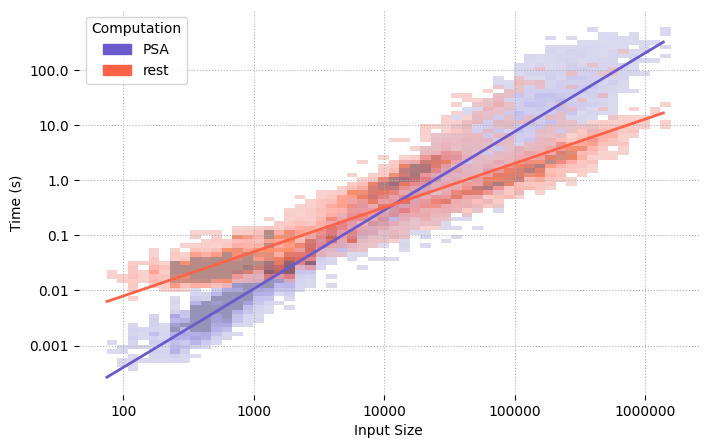

In [14]:
from sklearn.linear_model import LinearRegression

colors = [sn.color_palette("mako")[i] for i in [1, 3]]
colors = ["slateblue", "darkolivegreen"]

x_log = np.log10(plot_df["Input Size"])
y_log = np.log10(plot_df["Time (s)"])

plt.figure(figsize=(8, 5))
ax = sn.histplot(
    x=x_log,
    y=y_log,
    hue=plot_df["Computation"],
    palette=["slateblue", "tomato"],
    binwidth=0.08,
    alpha=0.6,
    common_norm=False,
    pthresh=0,
    pmax=0.7,
)
log_xticks = np.arange(2, 7)
log_yticks = np.arange(-3, 3)

plt.xlabel("Input Size")
plt.ylabel("Time (s)")
plt.xticks(log_xticks, labels=10**log_xticks)
plt.yticks(log_yticks, labels=10.0**log_yticks)

ax.grid(linestyle=":")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["bottom"].set_visible(False)

sn.move_legend(ax, "upper left")

colors = ["slateblue", "tomato"]
for i, computation in enumerate(plot_df["Computation"].unique()):
    mask = plot_df["Computation"] == computation
    x_vals = x_log[mask].to_numpy().reshape(-1, 1)
    y_vals = y_log[mask].to_numpy()
    model = LinearRegression().fit(x_vals, y_vals)
    x_fit = np.linspace(x_vals.min(), x_vals.max(), 100).reshape(-1, 1)
    y_fit = model.predict(x_fit)
    ax.plot(x_fit.flatten(), y_fit, color=colors[i], lw=2, label=f"{computation} fit")


plt.savefig(
    ROOT.parent / "figures" / "computation_psa_vs_rest.svg", bbox_inches="tight"
)

## Sample 84 datasets of different sizes

In [ ]:
plot_df = perf_df.sum(axis=1).to_frame()
plot_df.columns = ["Time (s)"]
plot_df["Count"] = feat_df["num_seqs"].loc[plot_df.index]
plot_df["Length"] = feat_df["max.seq_length"].loc[plot_df.index]
plot_df["Input Size"] = plot_df["Count"] * plot_df["Length"]
strat_col = pd.cut(
    plot_df["Input Size"],
    bins=[
        0,
        1000,
        2500,
        5000,
        10000,
        25000,
        50000,
        100000,
        250000,
        500000,
        750000,
        1000000,
        1500000,
    ],
)
sample = plot_df.groupby(strat_col, observed=True).sample(n=7).reset_index().iloc[:, :2]
print(sample.shape)
# sample.to_parquet(ROOT.parent / "logs" / "misc" / "runtime_sample.parquet")

path = Path("/hits/fast/cme/bodynems/data/paper") / sample.iat[0, 0] / sample.iat[0, 1]
print(os.listdir(path))
print(os.listdir(path / "se"))

(84, 2)
['stats.parquet', 'MAFFT_L-INS-i', 'MAFFT_G-INS-i', 'ensemble', 'ClustalO', 'Muscle3', 'MAFFT_FFT-NS-2', 'Muscle5', 'sequences.fasta']


FileNotFoundError: [Errno 2] No such file or directory: '/hits/fast/cme/bodynems/data/paper/bralibase_k5/Intron_gpII.apsi-49.sci-66.no-1/se'

<Axes: ylabel='Time (s)'>

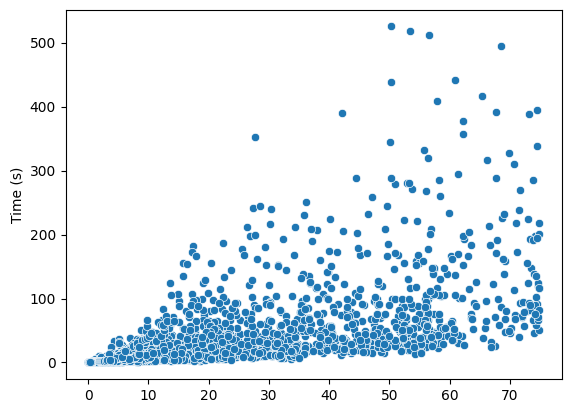

In [ ]:
# from scipy.stats import iqr
# from matplotlib.ticker import FormatStrFormatter
# from sklearn.svm import SVR

plot_df = perf_df.sum(axis=1).to_frame()
plot_df.columns = ["Time (s)"]
plot_df["Count"] = feat_df["num_seqs"].loc[plot_df.index]
plot_df["Length"] = feat_df["max.seq_length"].loc[plot_df.index]
plot_df["Input Size"] = plot_df["Count"] * plot_df["Length"]


X = plot_df[["Count", "Length", "Input Size"]]
y = plot_df["Time (s)"]

reg = SVR().fit(X, y)
y_pred = reg.predict(X)

sn.scatterplot(x=y_pred, y=y)

# table_idxs = (
#     plot_df["Input Size"].sort_values().iloc[np.arange(0, len(plot_df), 500)].index
# )
# # plot_df = plot_df.loc[table_idxs].reset_index(drop=True).iloc[:,[-3,-2,0]]

# plot_df[["Input Size"]].groupby("Input Size").count()
# # plot_df["Time (s)"] = plot_df["Time (s)"].round(2).astype(str)

# # plot_df = plot_df.T
# # plot_df
# # plot_df[["Count", "Length"]] = plot_df[["Count", "Length"]].astype(int)
# plot_df["Bin"] = pd.cut(
#     plot_df["Input Size"],
#     bins=[0, 2500, 5000, 10000, 20000, 50000, 100000, 500000, 1000000, 1400000],
# )
# plot_df = plot_df.groupby("Bin", observed=True).aggregate(["count", "median", iqr])
# plot_df = plot_df[[("Time (s)", "count"), ("Time (s)", "median"), ("Time (s)", "iqr")]]
# plot_df.round(2)
# plot_df.columns.droplevel()

# ax = sn.boxplot(
#     data=plot_df,
#     # x=pd.cut(plot_df["Input Size"], bins = [0, 2500, 5000, 10000, 20000, 50000, 100000, 500000, 1000000, 1400000]),
#     x=pd.cut(
#         plot_df["Input Size"],
#         # bins=[0, 2500, 5000, 10000, 20000, 50000, 100000, 500000, 1000000, 1500000],
#         bins=[0] + list(2 ** np.arange(10, 23)),
#     ),
#     y="Time (s)",
#     gap=0.5,
#     zorder=2,
#     # flierprops={"marker": "x"},
# )
# xticklabels = plt.gca().get_xticklabels()
# _ = plt.gca().set_xticklabels(xticklabels, rotation=45)
# # ax.xaxis.set_major_formatter(FormatStrFormatter("%.2E"))
# plt.yscale("log")
# ax.grid(linestyle=":", axis="y", zorder=0)
# ax.spines["top"].set_visible(False)
# ax.spines["right"].set_visible(False)
# ax.spines["left"].set_visible(False)
# ax.spines["bottom"].set_visible(False)

/tmp/ipykernel_1489560/1984594484.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = plt.gca().set_xticklabels(xticklabels, rotation=45)


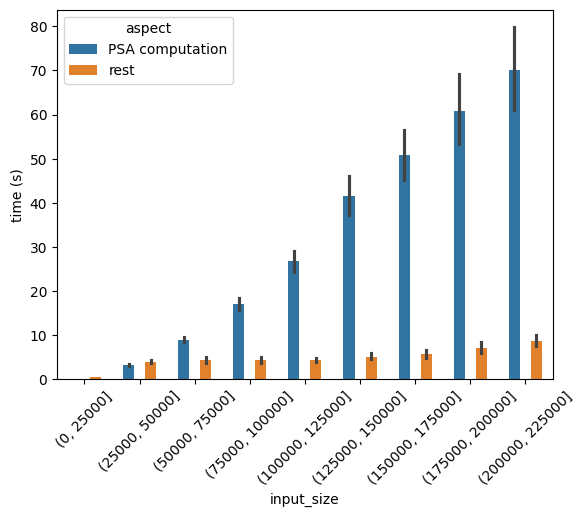

In [32]:
x = pd.cut(plot_df["input_size"], bins=np.arange(0, 250000, 25000))

sn.barplot(
    data=plot_df,
    x=x,
    y="time (s)",
    hue="aspect",
    gap=0.5,
    # flierprops={"marker": "x"},
)
xticklabels = plt.gca().get_xticklabels()
_ = plt.gca().set_xticklabels(xticklabels, rotation=45)

In [187]:
data_dir = Path("/hits/fast/cme/bodynems/data/benchmarking")
sample = pd.read_parquet(ROOT.parent / "logs" / "misc" / "runtime_sample.parquet")

perf_dict = {}
for i in range(len(sample)):
    source, dataset = sample.iloc[i, :]
    # os.makedirs(OUT_DIR / source / dataset / "ensemble")
    in_file = data_dir / source / dataset
    for handle in os.listdir(in_file):
        if os.path.isdir(in_file / handle) and not handle == "ensemble":
            bench_file = in_file / handle / "bench_ensemble.txt"
            if os.path.exists(bench_file):
                tool = bench_file.parent.name
                line = open(bench_file).readlines()[1]
                cpu_time = float(line.split("\t")[-1])
                perf_dict[(source, dataset, tool)] = cpu_time
            # else:
            #     print("[NOT DONE]", source, dataset)

In [220]:
perf_df = pd.DataFrame(
    perf_dict.values(),
    index=perf_dict.keys(),
    columns=["Time (s)"],
)
perf_df.index.names = ["source", "dataset", "tool"]
timeouts = (
    6
    - perf_df[["Time (s)"]]
    .reset_index()
    .drop(["tool"], axis=1)
    .groupby(["source", "dataset"])
    .count()
)
perf_df.to_parquet(ROOT.parent / "logs" / "misc" / "ensemble_time_detailed.parquet")

perf_df = (
    perf_df.reset_index().drop("tool", axis=1).groupby(["source", "dataset"]).sum()
)

timeouts = timeouts.loc[perf_df.index]

perf_df = perf_df + timeouts * 3600
perf_df.to_parquet(ROOT.parent / "logs" / "misc" / "ensemble_time.parquet")
perf_df

Time (s)
source        dataset                               
arthropod     CYP_20                          155.38
              CYP_307                        5510.53
bali3         BBS12037                       3724.57
              BBS20040                       1176.85
bralibase_k15 HIV_GSL3.apsi-89.sci-66.no-1     36.63
...                                              ...
treebase_v1   26800_3.phy                     549.70
              27350_0.phy                    4676.67
              27596_39.phy                   8919.63
              28078_1.phy                   11074.72
              28099_0.phy                    7590.25

[84 rows x 1 columns]

In [239]:
import seaborn as sn
import matplotlib.pyplot as plt

perf_e = pd.read_parquet(ROOT.parent / "logs" / "misc" / "ensemble_time.parquet")
perf_h = pd.read_parquet(ROOT.parent / "logs" / "misc" / "heuristic_time.parquet")
perf_p = pd.read_parquet(ROOT.parent / "logs" / "misc" / "prediction_time.parquet")


perf_h.sort_values("Time (s)", ascending=False)

perf_df = pd.concat([perf_e, perf_h, perf_p], join="outer", axis=1)
# perf_df = perf_df.fillna(perf_df.max(axis=0), axis=0)
print(perf_df.isna().mean())
perf_df = perf_df.fillna(3600, axis=0)
perf_df.columns = ["ensemble", "heuristic", "predict"]

perf_df = pd.concat([perf_df, feat_df], join="inner", axis=1)
perf_df["Input Size"] = perf_df["num_seqs"] * perf_df["max.seq_length"]

Time (s)    0.0
Time (s)    0.0
Time (s)    0.0
dtype: float64


<Axes: xlabel='Input Size', ylabel='ensemble'>

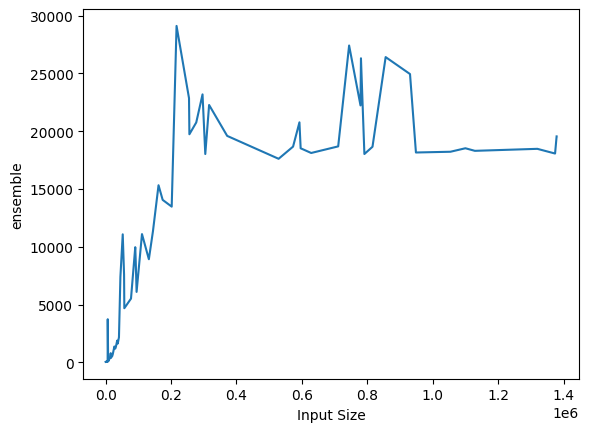

In [240]:
sn.lineplot(x=perf_df["Input Size"], y=perf_df.ensemble)

In [241]:
perf_df = perf_df.melt(
    id_vars=list(feat_df.columns) + ["Input Size"],
    value_vars=["ensemble", "heuristic", "predict"],
    var_name="Aspect",
    value_name="Time (s)",
)
perf_df["bin"] = pd.cut(
    perf_df["Input Size"],
    bins=[
        0,
        5000,
        10000,
        50000,
        100000,
        500000,
        1500000,
    ],
)

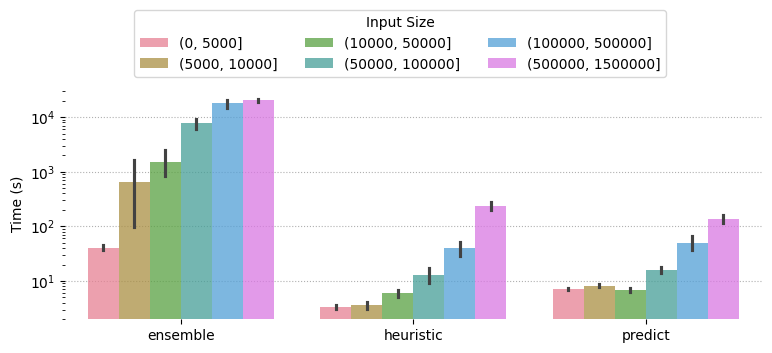

In [242]:
plt.figure(figsize=(9, 3))
ax = sn.barplot(
    perf_df,
    x="Aspect",
    y="Time (s)",
    hue="bin",
    zorder=2,
    palette=sn.color_palette("husl", 6),
    # palette=sn.cubehelix_palette(11),
    alpha=0.75,
)
plt.yscale("log")

ax.grid(linestyle=":", axis="y")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.set_xlabel("")
sn.move_legend(ax, loc=(0.1, 1.05), ncol=3, title="Input Size")

plt.savefig(ROOT.parent / "figures" / "runtime_comparison.svg")